In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import  pickle
pickleFile = open('/content/drive/MyDrive/Snap_dataset/y_18.pickle', 'rb')
y = pickle.load(pickleFile)

from collections import Counter
type(y), len(y), Counter(y)

(list,
 3445,
 Counter({0: 111,
          1: 102,
          2: 134,
          3: 123,
          4: 110,
          5: 736,
          6: 107,
          7: 286,
          8: 179,
          9: 117,
          10: 148,
          11: 169,
          12: 284,
          13: 228,
          14: 207,
          15: 104,
          16: 149,
          17: 151}))

In [19]:
from collections import Counter
print(Counter([x for x, index in zip(y, val) if index == True]))
print(Counter([x for x, index in zip(y, val) if index == False]))

Counter({5: 515, 7: 200, 12: 198, 13: 159, 14: 144, 8: 125, 11: 118, 17: 105, 16: 104, 10: 103, 2: 93, 3: 86, 9: 81, 4: 77, 0: 77, 6: 74, 15: 72, 1: 71})
Counter({5: 221, 12: 86, 7: 86, 13: 69, 14: 63, 8: 54, 11: 51, 17: 46, 10: 45, 16: 45, 2: 41, 3: 37, 9: 36, 0: 34, 6: 33, 4: 33, 15: 32, 1: 31})


In [18]:
pickleFile = open('/content/drive/MyDrive/Snap_dataset/is_train_18.pickle', 'rb')
val = pickle.load(pickleFile)

# val
# type(val), len(val), type(val[0]), val[0].shape

In [40]:
pickleFile = open('/content/drive/MyDrive/Snap_dataset/x_18.pickle', 'rb')
X = pickle.load(pickleFile)

type(X), len(X), type(X[0]), X[0].shape

(list, 3445, numpy.ndarray, (224, 224, 3))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2cab3b40f0>,
 <matplotlib.image.AxesImage at 0x7f2caa895940>)

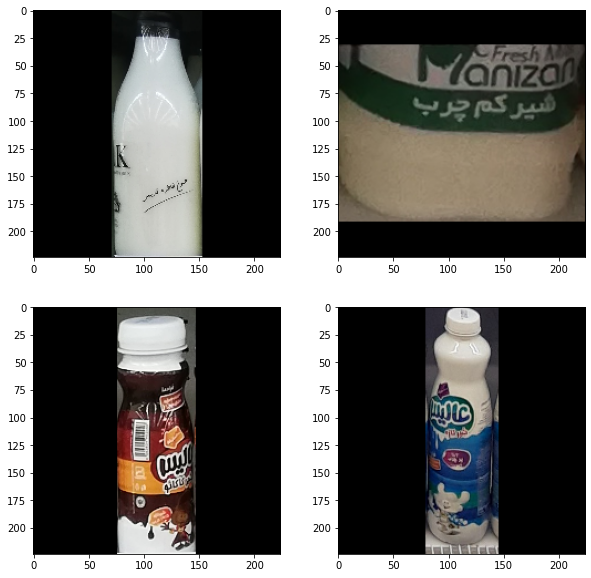

In [21]:
import matplotlib.pyplot as plt
i=0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(X[i])
plt.subplot(222), plt.imshow(X[i+23])
plt.subplot(223), plt.imshow(X[i+50])
plt.subplot(224), plt.imshow(X[i+75])

In [23]:
def crop_image_only_outside(img,tol=0):
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img>tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    return img[row_start:row_end,col_start:col_end]
    

In [24]:
img_black = []
img_sizes = []
from tqdm import tqdm
for img in tqdm(X):
  img = crop_image_only_outside(img)
  img_black.append(img)

  if img.shape not in img_sizes:
    img_sizes.append(img.shape)
    
img_sizes

100%|██████████| 3445/3445 [00:03<00:00, 1118.21it/s]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2cb88639b0>,
 <matplotlib.image.AxesImage at 0x7f2d11c0d898>)

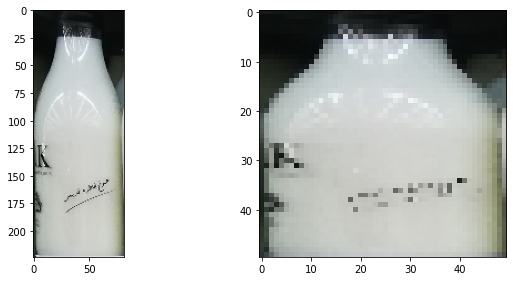

In [48]:
import tensorflow as tf
import cv2
# img_new = tf.image.resize(img_black[0], (224,224))
img_new = cv2.resize(img_black[0], (50, 50))
'train: ' ,img_new.shape, 'test ', img_black[0].shape


plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(img_black[0])
plt.subplot(222), plt.imshow(img_new)

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=5,
    scale={"x": (0.98, 1.02), "y": (0.98, 1.04)}
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(X_train)
# for x, y in datagen.flow(X_train, y_train, batch_size=32):
#   plt.imshow(x[0])
#   plt.show()
#   break

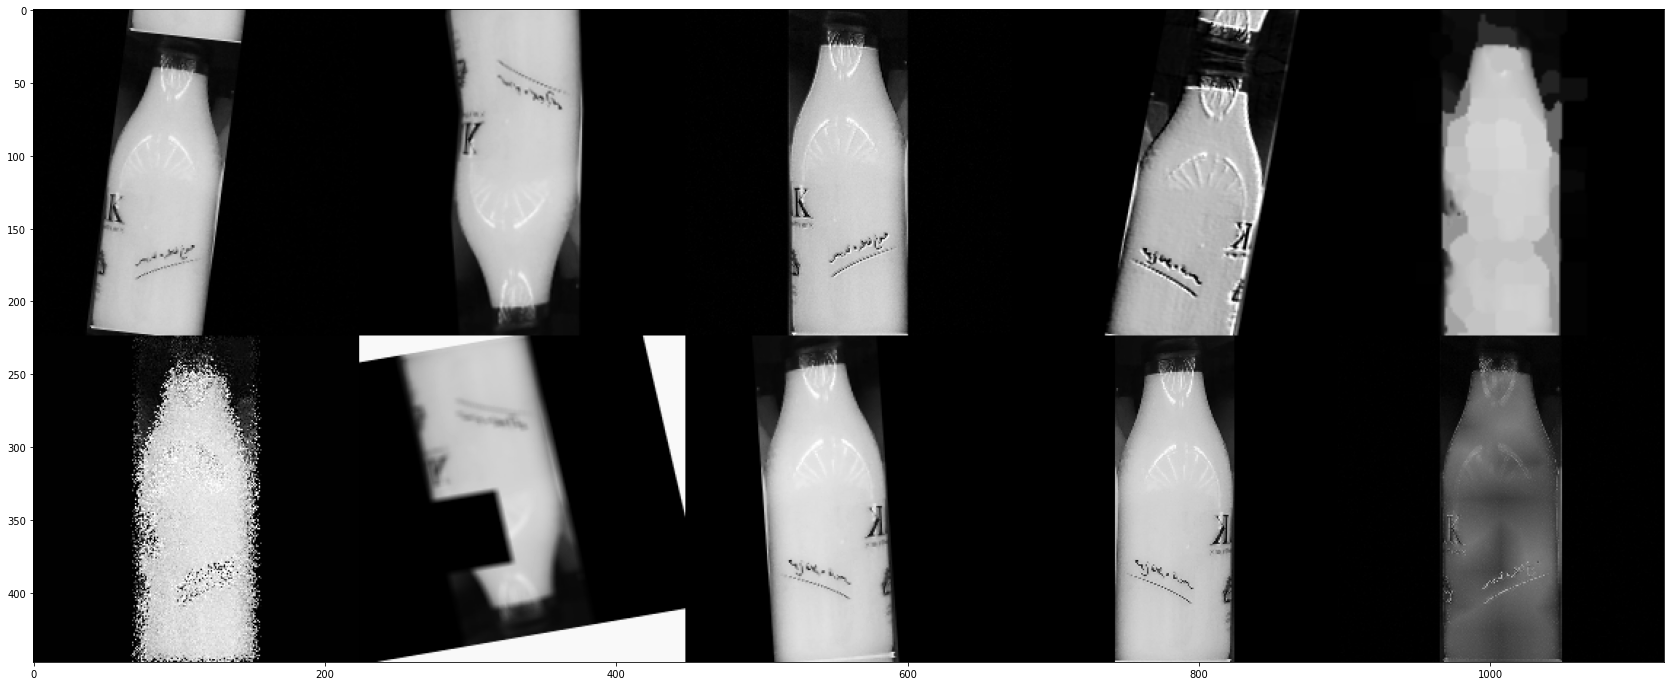

In [42]:
import imgaug as ia
from imgaug import augmenters as iaa
# Image augmentation (light but constant)

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
augmentation = iaa.Sequential(
        [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.2),  # vertically flip 20% of all images
        sometimes(iaa.Affine(
          scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
          # scale images to 80-120% of their size, individually per axis
          translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
          # translate by -20 to +20 percent (per axis)
          rotate=(-10, 10),  # rotate by -45 to +45 degrees
          shear=(-5, 5),  # shear by -16 to +16 degrees
          order=[0, 1],
          # use nearest neighbour or bilinear interpolation (fast)
          cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
          mode=ia.ALL
          # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
                    [sometimes(iaa.Superpixels(p_replace=(0, 1.0),
                                                  n_segments=(20, 200))),
                      # convert images into their superpixel representation
                      iaa.OneOf([
                          iaa.GaussianBlur((0, 1.0)),
                          # blur images with a sigma between 0 and 3.0
                          iaa.AverageBlur(k=(3, 5)),
                          # blur image using local means with kernel sizes between 2 and 7
                          iaa.MedianBlur(k=(3, 5)),
                          # blur image using local medians with kernel sizes between 2 and 7
                      ]),
                      iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)),
                      # sharpen images
                      iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                      # emboss images
                      # search either for all edges or for directed edges,
                      # blend the result with the original image using a blobby mask
                      iaa.SimplexNoiseAlpha(iaa.OneOf([
                          iaa.EdgeDetect(alpha=(0.5, 1.0)),
                          iaa.DirectedEdgeDetect(alpha=(0.5, 1.0),
                                                direction=(0.0, 1.0)),
                      ])),
                      iaa.AdditiveGaussianNoise(loc=0,
                                                scale=(0.0, 0.01 * 255),
                                                per_channel=0.5),
                      # add gaussian noise to images
                      iaa.OneOf([
                          iaa.Dropout((0.01, 0.05), per_channel=0.5),
                          # randomly remove up to 10% of the pixels
                          iaa.CoarseDropout((0.01, 0.03),
                                            size_percent=(0.01, 0.02),
                                            per_channel=0.2),
                      ]),
                      iaa.Invert(0.01, per_channel=True),
                      # invert color channels
                      iaa.Add((-2, 2), per_channel=0.5),
                      # change brightness of images (by -10 to 10 of original value)
                      iaa.AddToHueAndSaturation((-1, 1)),
                      # change hue and saturation
                      # either change the brightness of the whole image (sometimes
                      # per channel) or change the brightness of subareas
                      iaa.OneOf([
                          iaa.Multiply((0.9, 1.1), per_channel=0.5),
                          iaa.FrequencyNoiseAlpha(
                              exponent=(-1, 0),
                              first=iaa.Multiply((0.9, 1.1),
                                                per_channel=True),
                              second=iaa.ContrastNormalization(
                                  (0.9, 1.1))
                          )
                      ]),
                      sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5),
                                                          sigma=0.25)),
                      # move pixels locally around (with random strengths)
                      sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                      # sometimes move parts of the image around
                      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                    ],
                    random_order=True
                    )
        ],
        random_order=True
    )


# test on the same image as above
imggrid = augmentation.draw_grid(X[0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [66]:
import numpy as np
import pandas as pd
import time
import keras
import matplotlib.pyplot as plt
import  pickle
import cv2

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D
# from keras.applications.nasnet import NASNetMobile, preprocess_input
# from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg16 import preprocess_input

# New
from keras.applications import VGG19
from keras.applications import VGG16

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback

from keras.utils import to_categorical

import imgaug as ia
from imgaug import augmenters as iaa

from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix

In [67]:
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, images_paths, labels, batch_size=64, image_dimensions = (224, 224, 3), shuffle=False, augment=False):
    self.labels       = labels              # array of labels
    self.images_paths = images_paths        # array of image paths
    self.dim          = image_dimensions    # image dimensions
    self.batch_size   = batch_size          # batch size
    self.shuffle      = shuffle             # shuffle bool
    self.augment      = augment             # augment data bool
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.images_paths) / self.batch_size))

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.images_paths))
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    'Generate one batch of data'
    # selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

    # select data and load images
    labels = np.array([self.labels[k] for k in indexes])
    images = np.array([self.images_paths[k] for k in indexes])
        
    # preprocess and augment data
    if self.augment == True:
        images = self.augmentor(images)
    
    # image = np.array(images)/255
    images = np.array([preprocess_input(img) for img in images])

    return images, labels
    
  def augmentor_keras(self, images):
    augs_gen = ImageDataGenerator(
            featurewise_center=False,  
            samplewise_center=False, 
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,  
            zca_whitening=False,  
            rotation_range=10,  
            zoom_range = 0.1, 
            width_shift_range=0.2,  
            height_shift_range=0.2, 
            horizontal_flip=True,  
            vertical_flip=False) 
    
    augs_gen.fit(x_train)


  def augmentor(self, images):
    'Apply data augmentation'
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.2),  # vertically flip 20% of all images
        sometimes(iaa.Affine(
          scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
          # scale images to 80-120% of their size, individually per axis
          translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
          # translate by -20 to +20 percent (per axis)
          rotate=(-10, 10),  # rotate by -45 to +45 degrees
          shear=(-5, 5),  # shear by -16 to +16 degrees
          order=[0, 1],
          # use nearest neighbour or bilinear interpolation (fast)
          cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
          mode=ia.ALL
          # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
                    [sometimes(iaa.Superpixels(p_replace=(0, 1.0),
                                                  n_segments=(20, 200))),
                      # convert images into their superpixel representation
                      iaa.OneOf([
                          iaa.GaussianBlur((0, 1.0)),
                          # blur images with a sigma between 0 and 3.0
                          iaa.AverageBlur(k=(3, 5)),
                          # blur image using local means with kernel sizes between 2 and 7
                          iaa.MedianBlur(k=(3, 5)),
                          # blur image using local medians with kernel sizes between 2 and 7
                      ]),
                      iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)),
                      # sharpen images
                      iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                      # emboss images
                      # search either for all edges or for directed edges,
                      # blend the result with the original image using a blobby mask
                      iaa.SimplexNoiseAlpha(iaa.OneOf([
                          iaa.EdgeDetect(alpha=(0.5, 1.0)),
                          iaa.DirectedEdgeDetect(alpha=(0.5, 1.0),
                                                direction=(0.0, 1.0)),
                      ])),
                      iaa.AdditiveGaussianNoise(loc=0,
                                                scale=(0.0, 0.01 * 255),
                                                per_channel=0.5),
                      # add gaussian noise to images
                      iaa.OneOf([
                          iaa.Dropout((0.01, 0.05), per_channel=0.5),
                          # randomly remove up to 10% of the pixels
                          iaa.CoarseDropout((0.01, 0.03),
                                            size_percent=(0.01, 0.02),
                                            per_channel=0.2),
                      ]),
                      iaa.Invert(0.01, per_channel=True),
                      # invert color channels
                      iaa.Add((-2, 2), per_channel=0.5),
                      # change brightness of images (by -10 to 10 of original value)
                      iaa.AddToHueAndSaturation((-1, 1)),
                      # change hue and saturation
                      # either change the brightness of the whole image (sometimes
                      # per channel) or change the brightness of subareas
                      iaa.OneOf([
                          iaa.Multiply((0.9, 1.1), per_channel=0.5),
                          iaa.FrequencyNoiseAlpha(
                              exponent=(-1, 0),
                              first=iaa.Multiply((0.9, 1.1),
                                                per_channel=True),
                              second=iaa.ContrastNormalization(
                                  (0.9, 1.1))
                          )
                      ]),
                      sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5),
                                                          sigma=0.25)),
                      # move pixels locally around (with random strengths)
                      sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                      # sometimes move parts of the image around
                      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                    ],
                    random_order=True
                    )
        ],
        random_order=True
    )
    return seq.augment_images(images)
	

In [92]:
class NetModel():
  def __init__(self, image_dimensions=(224,224 ,3), n_classes=18):
    self.n_classes = n_classes  # number of classes to classify(1 for binary classification)
    self.input_dim = image_dimensions  # image input dimensions
    self.model = self.create_model()  # model

  def summary(self):
    self.model.summary()

  def create_model(self):
    input_layer = Input(self.input_dim)
        
    # nas_mobile_model = NASNetMobile(include_top=False, input_tensor=input_layer, weights='imagenet')
    # x = nas_mobile_model(input_layer)

    vgg = VGG16(input_tensor=input_layer, weights='imagenet', include_top=False)

    vgg.trainable = False

    for layer in vgg.layers:
        print(layer.name, layer.trainable)

    x = vgg(input_layer)

    # output layers
    x1 = GlobalAveragePooling2D()(x)
    x2 = GlobalMaxPooling2D()(x)
    x3 = Flatten()(x)

    out = Concatenate(axis=-1)([x1, x2, x3])
    out = Dropout(0.5)(out)
    out = Dense(100)(out)
    output_layer = Dense(self.n_classes, activation='softmax')(out)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(lr=0.005), loss="categorical_crossentropy", metrics=['acc'])
    return model


  def train(self, train_data, val_data, plot_results=True):
    'Trains data on generators'
    print("Starting training")

    # reduces learning rate if no improvement are seen
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.0000001)

    # stop training if no improvements are seen
    early_stop = EarlyStopping(monitor="val_loss",
                                mode="min",
                                patience=1,
                                restore_best_weights=True)

    # saves model weights to file
    checkpoint = ModelCheckpoint('./model_weights.hdf5',
                                  monitor='val_loss',
                                  verbose=3,
                                  save_best_only=True,
                                  mode='min',
                                  save_weights_only=True)

    # visualize training data
    # tensorboard = TensorBoard(log_dir='./logs',
    #                          histogram_freq=0,
    #                          batch_size=BATCH_SIZE,
    #                          write_graph=True,
    #                          write_grads=True,
    #                          write_images=False)

    # reduce resource usage(keeps laptop from melting)
    # idle = LambdaCallback(on_epoch_end=lambda batch, logs: time.sleep(30),
    #                      on_batch_end=lambda batch, logs: time.sleep(0.005))

    # train on data
    history = self.model.fit(train_data,
                              validation_data=val_data,
                              epochs=EPOCHS,
                              steps_per_epoch=len(train_data),
                              validation_steps =len(val_data),
                              callbacks=[learning_rate_reduction, early_stop, checkpoint],
                              verbose=1
                              )
    # plot training history
    if plot_results:
      fig, ax = plt.subplots(2, 1, figsize=(6, 6))
      ax[0].plot(history.history['loss'], label="TrainLoss")
      ax[0].plot(history.history['val_loss'], label="ValLoss")
      ax[0].legend(loc='best', shadow=True)

      ax[1].plot(history.history['acc'], label="TrainAcc")
      ax[1].plot(history.history['val_acc'], label="ValAcc")
      ax[1].legend(loc='best', shadow=True)
      plt.show()

  def predict(self, test_data, y, weights_path):
    'Create basic file submit'
    self.model.load_weights(weights_path)
    # predict on data
    results = self.model.predict(test_data)

    # binarize prediction
    # rbin_pred = np.where(results > 0.5, 1, 0)
    # rbin_true = np.where(y > 0.5, 1, 0)

    y_pred = np.array(np.argmax(results, axis=1))
    y_true = np.array(np.argmax(y, axis=1))
    # print(len(y_pred), len(y_true))
    print(y_pred)
    print(y_true)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))


In [94]:
def crop_image_only_outside(img,tol=0):
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img>tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    return img[row_start:row_end,col_start:col_end]

def loadData(db, val_split=0.2, sub_sample_size=-1):
	'Loads data into generator object'
	if db == "train":
		data = pd.read_csv(f'../input/train_labels.csv')
		image_paths = data['id'].apply(lambda x: '../input/train/' + x + '.tif').values[:sub_sample_size]
		labels = data['label'].values[:sub_sample_size]
		if val_split > 0:
			X_train, X_test, Y_train, Y_test = train_test_split(image_paths, labels, test_size=val_split)
			train_data = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE, augment=True, shuffle=True)
			val_data = DataGenerator(X_test, Y_test, batch_size=BATCH_SIZE, augment=False, shuffle=False)
			return train_data, val_data
		else:
			return DataGenerator(image_paths, labels, batch_size=BATCH_SIZE, augment=True, shuffle=True), None

	else:
		data = pd.read_csv(f'../input/sample_submission.csv')
		image_paths = data['id'].apply(lambda x: '../input/test/' + x + '.tif').values
		labels = data['label'].values
		if sub_sample_size== -1 :
			return DataGenerator(image_paths, labels, batch_size=2), None
		else:
			return DataGenerator(image_paths[:sub_sample_size], labels[:sub_sample_size], batch_size=1), None

def loadData(val_split=0.2, sub_sample_size=-1):
  'Loads data into generator object'
  # Read Input Images
  pickleFile = open('/content/drive/MyDrive/Snap_dataset/x_18.pickle', 'rb')
  X = pickle.load(pickleFile)

  X_crop = []
  from tqdm import tqdm
  for img in tqdm(X):
    img = crop_image_only_outside(img)
    img = cv2.resize(img, (224, 224))
    X_crop.append(img)
  X = X_crop

  # Read Labels
  pickleFile = open('/content/drive/MyDrive/Snap_dataset/y_18.pickle', 'rb')
  y = pickle.load(pickleFile)
  y = to_categorical(y)

  pickleFile = open('/content/drive/MyDrive/Snap_dataset/is_train_18.pickle', 'rb')
  val = pickle.load(pickleFile)

  if val_split > 0:
    # X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=val_split)

    Y_train = [x for x, index in zip(y, val) if index == True]
    Y_test = [x for x, index in zip(y, val) if index == False]

    X_train = [x for x, index in zip(X, val) if index == True]
    X_test = [x for x, index in zip(X, val) if index == False]

    # X_train = np.array(X_train)/255
    # X_test = np.array(X_test)/255

    print('Train: ', len(X_train), ' Test: ', len(X_test))

    train_data = DataGenerator(X_train, Y_train, batch_size=BATCH_SIZE, augment=True, shuffle=True)
    val_data = DataGenerator(X_test, Y_test, batch_size=BATCH_SIZE, augment=False, shuffle=True)
    return train_data, val_data
  else:
    
    Y_test = [x for x, index in zip(y, val) if index == False]
    X_test = [x for x, index in zip(X, val) if index == False]
  
    return DataGenerator(X_test, Y_test, batch_size=1), Y_test
      


In [95]:
EPOCHS = 20
BATCH_SIZE = 32
IMAGE_DIMENSIONS = (224, 224, 3)

# create model
model = NetModel(image_dimensions=IMAGE_DIMENSIONS, n_classes=18)
model.summary()

# train model  
# train_data, val_data = loadData(val_split=0.2)
# model.train(train_data, val_data, plot_results=True)

# evaluate model using trained weights
val_data, y = loadData(val_split=0)
model.predict(val_data, y, weights_path='/content/drive/MyDrive/model_weights_best.hdf5')

input_42 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    input_42[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_41 (Gl (Non

100%|██████████| 3445/3445 [00:04<00:00, 831.09it/s]


[ 9  6  9 ... 17 17 17]
[ 6  6  9 ... 17 17 17]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       0.84      0.84      0.84        31
           2       1.00      0.98      0.99        41
           3       0.93      1.00      0.96        37
           4       0.80      0.85      0.82        33
           5       1.00      1.00      1.00       221
           6       1.00      0.73      0.84        33
           7       0.98      0.95      0.96        86
           8       0.98      0.94      0.96        54
           9       0.75      1.00      0.86        36
          10       0.88      0.62      0.73        45
          11       0.75      0.94      0.83        51
          12       0.99      0.95      0.97        86
          13       0.92      1.00      0.96        69
          14       1.00      0.98      0.99        63
          15       1.00      0.97      0.98        32
          16       1.00      0.89